# Quest Killarney Results Analyser
## by Barry Fitzgerald


In [1]:
# Setup imports and settings
import pandas as pd
import numpy as np
from IPython.display import Markdown
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
pd.set_option('display.max_rows', 1000)

In [2]:
# Get raw results data
raw_results = pd.read_html('http://www.redtagtiming.com/results/KAR_October_70km.html', attrs={'id': 'results'})[0]

In [3]:
# Clean data and convert all durations to hours
from datetime import datetime as dt
results = raw_results[:-1]
results = results.rename(columns=lambda c: c.replace(' ', '_').replace('.', '_').lower())
results = results.assign(strickeen=lambda x: pd.to_timedelta(x.strickeen) / np.timedelta64(1, 'h'),
               descent=lambda x: pd.to_timedelta(x.descent) / np.timedelta64(1, 'h'),
               torc=lambda x: pd.to_timedelta(x.torc) / np.timedelta64(1, 'h'),
               timeout=lambda x: pd.to_timedelta(x.timeout) / np.timedelta64(1, 'h'),
               kayak_start=lambda x: pd.to_timedelta(x.kayak_start) / np.timedelta64(1, 'h'),
               kayak_end=lambda x: pd.to_timedelta(x.kayak_end) / np.timedelta64(1, 'h'),
               mangerton=lambda x: pd.to_timedelta(x.mangerton) / np.timedelta64(1, 'h'),
               torc_1=lambda x: pd.to_timedelta(x.torc_1) / np.timedelta64(1, 'h'),
               finish=lambda x: pd.to_timedelta(x.finish) / np.timedelta64(1, 'h'),
               total=lambda x: pd.to_timedelta(x.total, errors='coerce') / np.timedelta64(1, 'h'),
               number=lambda x: x.number.astype(int)
              )
results['total_run'] = results.strickeen + results.descent + results.mangerton + results.torc_1
results['total_cycle'] = results.torc + results.finish

## Race Number:

In [4]:
race_number = 1482

In [5]:
# Get Athelete's results
my_results = results.ix[results.number == race_number].iloc[0]
md = []
md.append("## Athelete: " + my_results['name'] + ' ' + my_results.surname)
md.append('### Position: ' + str(my_results['place']))
md.append('### Total Time: ' + str(my_results['total'].round(2)) + ' (hours)')

Markdown('\n'.join(md))

## Athelete: Barry Fitzgerald
### Position: 145
### Total Time: 5.51 (hours)

---
# Finish Time Distributions

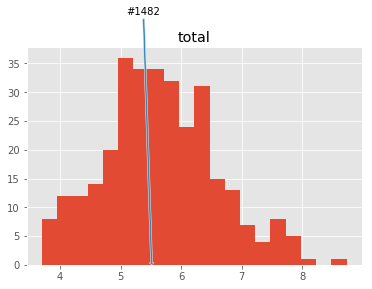

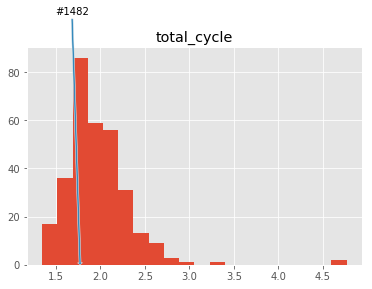

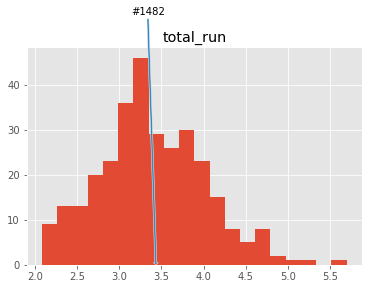

In [6]:
for t in ['total', 'total_cycle', 'total_run']:
    plt.figure()
    results[[t]].hist(bins=20, label='70km Total Time (hours)')
    plt.annotate('#' + str(race_number), xy=(my_results[t],0), xytext=(-25, 250),
                 arrowprops={'width': 2, 'headlength': 2,
                             'headwidth': 5},
                 textcoords='offset pixels')

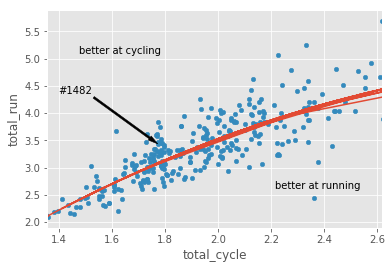

In [7]:
#X,Y scatter of run vs cycle times
filter_results = results[['total_cycle', 'total_run']].dropna()
ax = filter_results.plot.scatter(x='total_cycle', y='total_run')
plt.annotate('#' + str(race_number), xy=(my_results['total_cycle'], my_results['total_run']), xytext=(-100, 50),
                 arrowprops={'width': 2, 'headlength': 10,
                             'headwidth': 5, 'color': 'black'},
                 textcoords='offset pixels')


plt.annotate('better at cycling', xy=(0.2,0.8), xycoords='figure fraction')
plt.annotate('better at running', xy=(0.7,0.3), xycoords='figure fraction')


# get rid of some outliers for the trendline fit
filter_results['ratio'] = filter_results['total_cycle'] / filter_results['total_run']
upper_bound = filter_results['ratio'].quantile(0.95)
lower_bound = filter_results['ratio'].quantile(0.05)
fit_results = filter_results.ix[(filter_results['ratio'] < upper_bound) & (filter_results['ratio'] > lower_bound)]

# Relationship looks slightly curved - running is harder the less fit you are...
z = np.polyfit(x=fit_results['total_cycle'].values, y=fit_results['total_run'].values, deg=2)
p = np.poly1d(z)

trendline = pd.DataFrame(data=p(filter_results['total_cycle'].values), index=filter_results['total_cycle'].values)
trendline.name= 'trend' 
trendline.plot(ax=ax, legend=False)